# Author Problems
We'll start off by investigating the *author* field. This is an area that was found to have a number of potentially high priority issues as it pertains to social and political matters, as well as a field that has seen the some of the most pervasive issues in standardization. 

Start by importing the packages we'll need, setting up our directories, and loading in the data.

In [1]:
import pandas as pd #Creating dataframe and manipulating data
from bs4 import BeautifulSoup as bs # for cleaning xml tags
import re #regular expressions used for detection of initials
import seaborn as sns # data visualizations
from pathlib import Path

In [2]:
# Data Directory
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
# Loading in dataset
df = pd.read_csv(input_dir / 'cleaned_data.csv', parse_dates=['indexed', 'created', 'deposited'], infer_datetime_format=True)
df.head()

,Index,indexed,publisher,content-domain,short-container-title,DOI,created,is-referenced-by-count,title,prefix,volume,author,member,reference,container-title,language,link,deposited,resource,issued,references-count,journal-issue,URL,subject,alternative-id,assertion,abstract,original-title,subtitle,editor
0,0,2022-10-07,Wiley,"{'domain': [], 'crossmark-restriction': False}",Syst. Dyn. Rev.,10.1002/(sici)1099-1727(200021)16:1<27::aid-sd...,2002-09-10,57,The validation of commercial system dynamics m...,10.1002,16,"[{'given': 'Geoff', 'family': 'Coyle', 'sequen...",311.0,[{'key': '10.1002/(SICI)1099-1727(200021)16:1<...,System Dynamics Review,en,[{'URL': 'https://api.wiley.com/onlinelibrary/...,2021-07-01,{'primary': {'URL': 'https://onlinelibrary.wil...,{'date-parts': [[2000]]},14,"{'issue': '1', 'published-print': {'date-parts...",http://dx.doi.org/10.1002/(sici)1099-1727(2000...,"['Management of Technology and Innovation', 'S...",NaN,NaN,NaN,NaN,NaN,NaN
1,1,2022-03-29,Springer Science and Business Media LLC,"{'domain': [], 'crossmark-restriction': False}",MTB,10.1007/bf02653972,2007-07-17,20,Effect of system geometry on the leaching beha...,10.1007,10,"[{'given': 'C.', 'family': 'Vu', 'sequence': '...",297.0,"[{'key': 'BF02653972_CR1', 'volume-title': 'Ph...",Metallurgical Transactions B,en,[{'URL': 'http://link.springer.com/content/pdf...,2019-05-20,{'primary': {'URL': 'http://link.springer.com/...,"{'date-parts': [[1979, 3]]}",12,"{'issue': '1', 'published-print': {'date-parts...",http://dx.doi.org/10.1007/bf02653972,"['Materials Chemistry', 'Metals and Alloys', '...",['BF02653972'],NaN,NaN,NaN,NaN,NaN
2,2,2022-03-30,Wiley,"{'domain': [], 'crossmark-restriction': False}",RECIEL,10.1111/reel.12221,2017-12-01,2,The international law on transboundary haze po...,10.1111,26,"[{'given': 'Shawkat', 'family': 'Alam', 'seque...",311.0,NaN,"Review of European, Comparative &amp; Internat...",en,[{'URL': 'https://api.wiley.com/onlinelibrary/...,2017-12-01,{'primary': {'URL': 'http://doi.wiley.com/10.1...,"{'date-parts': [[2017, 11]]}",0,"{'issue': '3', 'published-print': {'date-parts...",http://dx.doi.org/10.1111/reel.12221,"['Law', 'Management, Monitoring, Policy and La...",NaN,NaN,NaN,NaN,NaN,NaN
3,3,2022-04-03,Crop Science Society of Japan,"{'domain': [], 'crossmark-restriction': False}","Japanese journal of crop science', 'Jpn. J. Cr...",10.1626/jcs.20.219,2011-09-20,0,Studies on the influence of pruning on the veg...,10.1626,20,"[{'given': 'C.', 'family': 'TSUDA', 'sequence'...",632.0,NaN,Japanese Journal of Crop Science,en,[{'URL': 'http://www.jstage.jst.go.jp/article/...,2021-04-30,{'primary': {'URL': 'http://www.jstage.jst.go....,{'date-parts': [[1951]]},0,"{'issue': '1-2', 'published-print': {'date-par...",http://dx.doi.org/10.1626/jcs.20.219,"['Genetics', 'Agronomy and Crop Science', 'Foo...",NaN,NaN,NaN,NaN,NaN,NaN
4,4,2022-03-31,Elsevier BV,"{'domain': ['clinicalkey.fr', 'elsevier.com', ...",Revue de Pneumologie Clinique,10.1016/j.pneumo.2018.09.002,2018-10-10,0,Le tabagisme et l’aide à l’arrêt du tabac des ...,10.1016,74,"[{'given': 'J.', 'family': 'Perriot', 'sequenc...",78.0,[{'key': '10.1016/j.pneumo.2018.09.002_bib0305...,Revue de Pneumologie Clinique,fr,[{'URL': 'https://api.elsevier.com/content/art...,2019-10-26,{'primary': {'URL': 'https://linkinghub.elsevi...,"{'date-parts': [[2018, 12]]}",60,"{'issue': '6', 'published-print': {'date-parts...",http://dx.doi.org/10.1016/j.pneumo.2018.09.002,['Pulmonary and Respiratory Medicine'],['S0761841718301792'],"[{'value': 'Elsevier', 'name': 'publisher', 'l...",NaN,NaN,NaN,NaN


## Problem Detection Functions and Data Labeling
### Author Sequence
Our first function will be checking the *sequence* sub-field within the *author* field. This is the field wherein authors are either listed as 'first' or 'addtional'. This function sets up a counter then iterates through the author list of a record to check what the noted sequence is for each author.

The `try` block filters out records that have no authors listed. After that we begin to iterate through each author within a given record.

`If 'name' in author.keys():` is used to filter out institutions listed as authors as using the 'name' key is often how an institution is presented as an author within the metadata record. The code within the `if` block simply says if there's an institution as an author and they are the only author listed, increase the counter to 1, then the code will continue down to the `return` statements where **0** will be returned as technically there is not an issue with sequence in that record.

`else: if author['sequence'] == 'first'` block is where the bulk of the counting activity will happen. Up until this point we are mostly filtering out instances that don't apply to the problem at hand. Simply, the function will count how many authors are labled as 'first'. Once all authors of a record have been parsed, we go to the `return` statements.

In [3]:
def sequence_checker(authorList):
    counter = 0 
    try: 
        for author in authorList:
                if 'name' in author.keys():
                    if len(authorList) == 1:
                        counter +=1
                    else:
                        continue
                else:
                    if author['sequence'] == 'first':
                        counter +=1
                    else:
                        continue
        if counter == 0:
            return 1 #no first author
        elif counter > 1:
            return 1 #multiple first authors
        else:
            return 0 #no issue
    except:
        return None

In [4]:
# The 'author' and 'subject' columns need to be evaluated and formated before parsing,
# otherwise they are treated as strings instead of dicts/lists.
import ast
def reformat_col(record):
    try:
        formed = ast.literal_eval(record)
        return formed
    except:
        return None

cols_to_reformat = ['author', 'subject']
for col in cols_to_reformat:
    df[col] = df[col].apply(lambda x: reformat_col(x))

In [5]:
author_sequence_issues = df.author.map(lambda x: sequence_checker(x))
df['author_sequence'] = author_sequence_issues #inserting a column with our data labels

In [6]:
records_with_AuSeq = df.loc[(df.author_sequence == 1) | (df.author_sequence == 2)] #creating a df with only the cords with these errors
prevalence_AuSeq = ((len(records_with_AuSeq))/(len(df.author_sequence))) * 100
prevalence_AuSeq #returning a percent of the total number of records with this particular issue

1.0472364035485202

### Author Initials
This function will utilize regular expressions for detecting the use of initials. Specifically, we are looking for when initials are used in totality, that is to say a record with "Marianne E." will not be flagged, whereas a record with "D." will.

We look in both the 'given' and the 'family' sub-fields as this use of initials has been found in both sub-fields previously. 

The flow of the function operates similarly to the `sequence_checker`, we filter out records with `null` authors in the first `try` statement, followed by iteration through the author list, then another `try` statement where we filter out institutions as authors.

The regular expressions can be broken into two conditions: `^(?:[A-Z]\W{,3}\s?){,3}` and `(?:[^\W\d_.]\W){1,2}\B` which are seperated by `|`. This is because each of those expressions are looking for initials, the former is looking in ASCII characters, whereas the latter s looking for the pattern in non-Latin characters.

`if detector != None or len(author['given']) == 1` insures that all initialized names are caught and then returned with the appropriate label.

In [7]:
def author_initials_checker(authorList):
    try: #Filter for no authors
        for author in authorList: #iterating through author array
            try: #filter for institutions as authors
                detector = re.match(r"^(?:[A-Z]\W{,3}\s?){,3}$|(?:[^\W\d_.]\W){1,2}\B$", author['given'].capitalize()) #checking for initials in given
                if detector != None or len(author['given']) == 1:
                    return 1 #initials used
                else:
                    family_detector = detector = re.match(r"^(?:[A-Z]\W{,3}\s?){,3}$|(?:[^\W\d_.]\W){1,2}\B$", author['family'].capitalize()) #initials in family
                    if family_detector != None or len(author['family']) == 1:
                        return 1 #initials used
                    else:
                        pass
            except:
                pass
                        
    except:
        return None
    return 0 #no issue

In [8]:
author_problems = df.author.map(lambda x: author_initials_checker(x))
df['author_initials'] = author_problems #setting up column with new data labels

In [9]:
records_with_initials = df.loc[df.author_initials == 1]
prevalence_author_initials = ((len(records_with_initials))/(len(df.author_initials))) * 100
prevalence_author_initials # percentage of records with this specific issue

17.118287365696965

<AxesSubplot:xlabel='author_initials', ylabel='count'>

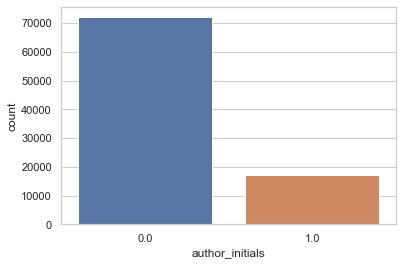

In [10]:
sns.set_theme(style='whitegrid')
sns.countplot(x=df['author_initials']) #simple plot to visualize the scale of the problem

### Institutions as Authors
This function will address instances in which institutions are recorded as authors.

`try:` will filter out records with `null` authors. Then we have the `institutions_present` list that looks for the telltale sign of an institution, the 'name' sub-field. 

If the list is populated with any authors, then the appropriate label signalling an institution will be returned.

In [11]:
def institution_as_author(authorList):
    try:
        institutions_present = [author for author in authorList if 'name' in author.keys()]
        if len(institutions_present) > 0:
            return 1 #institution as author
        else:
            return 0 #no issue
    except:
        return None

In [12]:
author_institutions = df.author.map(lambda x: institution_as_author(x))
df['author_institutions'] = author_institutions #new column with data labels

In [13]:
records_with_AuIns = df.loc[df.author_institutions == 1]
prevalence_AuIns = ((len(records_with_AuIns))/(len(df.author_institutions))) * 100
prevalence_AuIns #percentage of records with this specific issue

1.6806130360793081

### Non-Latin Characters

This function detects the use of non-latin character sets. Particularly we are interested in practices of romanization and when it occurs: which journals, are the *language* fields present and accurate, and so on. 

First, we have to identify which records are using non-latin characters.

This is split into two different functions. The first utilizes a regular expression `(?:[^ı́\x00-\xff])` to detect any characters not in ISO-8859-1 (or Latin-1) (See note).

The second then utlizes the first function to then check each author within a given record.

Note: This expression is providing a few too many false positives for my liking. I'm currently working on a better expression or a different solution entirely.

In [14]:
def isLatinChar(text):
    regexp = re.compile(r'(?:[^ı́\x00-\xff])')
    if regexp.search(text):
        return True
    else:
        return False
def latin_script_checker(authorList):
    try:
        latin_scripts = [author for author in authorList if isLatinChar(author['given'])]
        if len(latin_scripts) > 0:
            return 1 # non-latin script found
        else:
            return 0 # no issue
    except:
        return None

In [15]:
char_checker = df.author.map(lambda x: latin_script_checker(x))
df['author_characters'] = char_checker #new column with data labels

In [16]:
records_with_non_latin = df.loc[df.author_characters == 1]
prevalence_NonLatin = ((len(records_with_non_latin))/(len(df.author_institutions))) * 100
prevalence_NonLatin #percentage of records with this specific issue

1.941415178886103

In [17]:
records_missing_authors = df.loc[df.author.isnull()] # Finding all the records with null author values
prevalence_AuMis = ((len(records_missing_authors))/(len(df.author))) * 100
prevalence_AuMis # percentage of records with this specific issue

10.313264658792253

In [18]:
records_with_multiple = df.loc[((df.author_initials == 1) & (df.author_institutions == 1) & (df.author_sequence != 0) & (df.author_characters == 1))|
                              ((df.author_initials == 1) & (df.author_institutions == 1))|
                              ((df.author_institutions == 1) & (df.author_sequence != 0))|
                              ((df.author_initials == 1) & (df.author_sequence != 0))| 
                              ((df.author_characters == 1) & (df.author_initials == 1))| 
                              ((df.author_characters == 1) & (df.author_initials == 1) & (df.author_institutions == 1))| 
                              ((df.author_characters == 1) & (df.author_institutions == 1))|
                              ((df.author_characters == 1) & (df.author_sequence != 0))|
                              ((df.author_characters == 1) & (df.author_sequence != 0) & (df.author_institutions == 1))]
prevalence_multiple = ((len(records_with_multiple))/(len(df.author))) * 100
prevalence_multiple #percentage of records with more than one author issue

0.8730326556505453

In [19]:
len(records_with_multiple) #exact number of records in the df

867

In [20]:
records_with_multiple.head()

,Index,indexed,publisher,content-domain,short-container-title,DOI,created,is-referenced-by-count,title,prefix,volume,author,member,reference,container-title,language,link,deposited,resource,issued,references-count,journal-issue,URL,subject,alternative-id,assertion,abstract,original-title,subtitle,editor,author_sequence,author_initials,author_institutions,author_characters
80,81,2022-04-03,Oxford University Press (OUP),"{'domain': [], 'crossmark-restriction': False}",Eur Heart J Cardiovasc Imaging,10.1093/ehjci/jew247,2016-12-10,1,Clinical Case Poster session 1P501The incremen...,10.10930,17,"[{'given': 'P.', 'family': 'Lech', 'sequence':...",286.0,NaN,European Heart Journal – Cardiovascular Imaging,en,[{'URL': 'http://academic.oup.com/ehjcimaging/...,2017-08-24,{'primary': {'URL': 'https://academic.oup.com/...,"{'date-parts': [[2016, 12]]}",0,"{'issue': 'suppl 2', 'published-online': {'dat...",http://dx.doi.org/10.1093/ehjci/jew247,"[Cardiology and Cardiovascular Medicine, Radio...",['10.1093/ehjci/jew247'],NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0
212,215,2022-04-06,"Science China Press., Co. Ltd.","{'domain': ['engine.scichina.com'], 'crossmark...",Sci. Sin.-Phys. Mech. Astron.,10.1360/2010-40-1-55,2019-08-08,0,Si/SiO&amp;lt;sub&amp;gt;2&amp;lt;/sub&amp;gt;...,10.13600,40,"[{'given': '明', 'family': '徐', 'sequence': 'fi...",294.0,NaN,"SCIENTIA SINICA Physica, Mechanica &amp; Astro...",en,NaN,2019-08-08,{'primary': {'URL': 'http://engine.scichina.co...,"{'date-parts': [[2010, 2, 1]]}",0,"{'issue': '1', 'published-online': {'date-part...",http://dx.doi.org/10.1360/2010-40-1-55,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0
299,303,2022-04-03,ESG,"{'domain': [], 'crossmark-restriction': False}",Int. J. Electrochem. Sci.,10.20964/2018.08.15,2018-07-10,0,Water Contained Ionic Liquid Medium for Electr...,10.20964,NaN,"[{'given': 'G', 'family': 'Muthuraman', 'seque...",8561.0,NaN,International Journal of Electrochemical Science,NaN,[{'URL': 'http://www.electrochemsci.org/papers...,2018-07-10,{'primary': {'URL': 'http://www.electrochemsci...,"{'date-parts': [[2018, 8]]}",0,NaN,http://dx.doi.org/10.20964/2018.08.15,[Electrochemistry],NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN
429,433,2022-04-06,The Russian Academy of Sciences,"{'domain': [], 'crossmark-restriction': False}",Zh. Org. Khim.,10.31857/s0514749222010086,2022-01-06,0,СИНТЕЗ ПО РЕАКЦИИ РИТТЕРА И СВОЙСТВА БИС-ПРОИЗ...,10.31857,58,"[{'given': 'А.Г.', 'family': 'Михайловский', '...",17106.0,NaN,Журнал органической химии,NaN,NaN,2022-01-06,{'primary': {'URL': 'https://www.elibrary.ru/i...,"{'date-parts': [[2022, 1]]}",0,"{'issue': '1', 'published-online': {'date-part...",http://dx.doi.org/10.31857/s0514749222010086,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN
436,440,2022-04-11,Publishing House Helvetica (Publications),"{'domain': [], 'crossmark-restriction': False}",Право.ua,10.32782/law.ua.2021.1.24,2022-04-11,0,ІСТОРИКО-ПРАВОВІ ЗАСАДИ ФОРМУВАННЯ ДОКТРИНИ АМ...,10.32782,NaN,"[{'given': 'Р.Г.', 'family': 'ГУЛУЄВ', 'sequen...",17914.0,NaN,Право.ua,NaN,NaN,2022-04-11,{'primary': {'URL': 'http://pravo.unesco-socio...,{'date-parts': [[2021]]},0,"{'issue': '1', 'published-online': {'date-part...",http://dx.doi.org/10.32782/law.ua.2021.1.24,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0


In [21]:
records_with_multiple.publisher.value_counts() 
#Getting a sense of if specific publishers are more more likely to have multiple author realted errors

Hans Publishers                                                     56
Georg Thieme Verlag KG                                              47
Science China Press., Co. Ltd.                                      38
Wiley                                                               22
National Academy of Sciences of Ukraine (Co. LTD Ukrinformnauka)    18
                                                                    ..
Kyiv Politechnic Institute                                           1
American Meteorological Society                                      1
Belarusian-Russian University                                        1
Publishing House Ophthalmology                                       1
Gruppo Italiano Frattura                                             1
Name: publisher, Length: 341, dtype: int64

In [22]:
publisher_df = df.groupby(['publisher']).agg({'author_initials': ['sum'], 'author_institutions': ['sum'], 'author_sequence': ['sum'],
                                             'author_characters': ['sum']})

In [23]:
publisher_df #Checking around at the total number of author related errors by publisher

,author_initials,author_institutions,author_sequence,author_characters
,sum,sum,sum,sum
publisher,,,,
108 Institute of Clinical Medical and Pharmaceutical Sciences,0.0,0.0,0.0,1.0
19 Mayis Sosyal Bilimler Dergisi,0.0,0.0,0.0,0.0
19&20,0.0,0.0,0.0,0.0
A and V Publications,2.0,0.0,0.0,0.0
A.B. Bekturov Institute of Chemical Sciences,3.0,3.0,0.0,0.0
...,...,...,...,...
sdvig press,0.0,0.0,0.0,0.0
sub\urban e.V.,0.0,0.0,0.0,0.0


In [24]:
publisher_df.idxmax() #Which publishers have the most errors per error category

author_initials      sum                        Elsevier BV
author_institutions  sum    Philosophy Documentation Center
author_sequence      sum             Georg Thieme Verlag KG
author_characters    sum                              Wiley
dtype: object

In [25]:
publisher_df.max() 
#specific values of those publishers, although the 'author_sequence' one needs to be reworked because 
# a sum isn't quite an accurate measure as it isn't a simple binary. any occurences of '2' will skew
# it. It's on the list of things to address.

author_initials      sum    5204.0
author_institutions  sum     130.0
author_sequence      sum     174.0
author_characters    sum     205.0
dtype: float64

In [26]:
df.to_csv(output_dir / '03_author_issues_labeled.csv')